# Section 3. LangChain Chains

In LangChain, the concept of Chains refers to a sequence of connected steps that together form a more complex process. Each step can involve a different task, such as asking a question to a language model, retrieving information from a database, interpreting the result, and even sending an automated response. These steps work in a chain, where the output of one serves as the input for the next—much like an assembly line.

The main idea behind Chains is to enable the system to solve tasks that are more complex than a simple question-and-answer. For example, if we want to answer a question based on an article from the internet, we first need to retrieve that article, then extract the relevant content, pass that content to the language model, and only then generate the answer. Each of these actions would be a step in the Chain.

In [ ]:
!pip install dotenv
!pip install langchain_openai
!pip install -qU langchain-google-genai

In [ ]:
import getpass
import os

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import ChatOpenAI

def get_model_name(model_name, temperature=0):
    if model_name == "gemini": # https://ai.google.dev/gemini-api/docs/rate-limits?hl=pt-br
        if "GOOGLE_API_KEY" not in os.environ: # https://ai.google.dev/gemini-api/docs/api-key
            os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google AI API key: ")
        llm = ChatGoogleGenerativeAI(
            # model="gemini-1.5-pro", # max 50 / dia
            model="gemini-1.5-flash", # max 1500 / dia
            temperature=temperature,
        )
    elif model_name == "openai":
        if "OPENAI_API_KEY" not in os.environ: # https://platform.openai.com
            os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")
        llm = ChatOpenAI(
            model="gpt-4o-mini",
            temperature=temperature,
        )
    return llm

llm = get_model_name('gemini')

In this notebook, we’ll use a small data source available in the files for this module, so upload the `Data.csv` file to Google Colab and then run the line below.

In [ ]:
import pandas as pd
df = pd.read_csv('Data.csv')
df.head()

,Product,Review
0,Queen Size Sheet Set,I ordered a king size set. My only criticism w...
1,Waterproof Phone Pouch,"I loved the waterproof sac, although the openi..."
2,Luxury Air Mattress,This mattress had a small hole in the top of i...
3,Pillows Insert,This is the best throw pillow fillers on Amazo...
4,Milk Frother Handheld\n,I loved this product. But they only seem to l...


## 3.1 LLMChain

As we saw in the previous class, the simplest way to create a Chain in LangChain is by using the `|` syntax (known as the Runnable style), following the structure `prompt | llm`. Another way would be using `LLMChain`, but this method is deprecated in favor of Runnable.

In the following cell, we define our `StructuredOutput`. In this case, we want to receive only one company name that produces the given product. If we’re not specific about this, language models (LLMs) tend to return multiple options, which can break the rest of the Chain we’ll build next.

In [ ]:
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain
from pydantic import BaseModel, Field
from langchain_core.output_parsers import StrOutputParser

class StructuredOutput(BaseModel):
    company: str = Field(description='Company name')

# Step 2: Prompt Template
prompt = ChatPromptTemplate.from_template(
    "What is a very creative name for a company that makes {product}? Be creative and return a single name."
)

llm2 = llm.with_structured_output(StructuredOutput)

# Define the Chain using | syntax (Runnable style)
chain1 = prompt | llm2

product = "Queen Size Sheet Set"
result = chain1.invoke({"product": product})
print(result)

company="Queen's Slumber"


## 3.2 SimpleSequentialChain

As we saw in the previous class, the simplest way to create a Chain in LangChain is by using the | syntax (known as the Runnable style), following the structure prompt | llm.

Now we can really start building a Chain. In this lesson, we’ll base our approach on the Chain activity presented in the [lesson](https://learn.deeplearning.ai/courses/langchain/lesson/glsn3/chains). Unfortunately, the code used in that lesson is outdated (v0.0.), but in this notebook, we’ve updated the formats to the current version (v0.3.) whenever possible.

The first chain we’ll use is the [SimpleSequentialChain](https://python.langchain.com/api_reference/langchain/chains/langchain.chains.sequential.SimpleSequentialChain.html) class. This is a simple chain where the output of one step is used as the input for the next, as shown in the figure below.

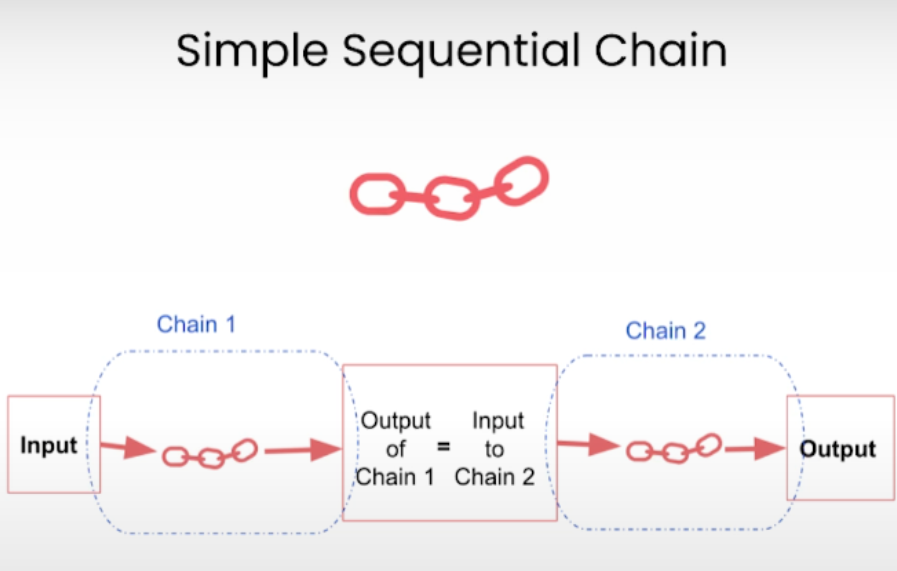



In the following example, we want to send a product to the LLM. The first LLM will be responsible for generating a creative name for a company that would produce this product, and then a second LLM will create a description for that company.

In the next cell, we present the traditional way of defining this chain using the `LLMChain` class. This approach is necessary because the `SimpleSequentialChain` class is not compatible with `Runnable` objects. After that, we’ll show how to implement the same logic using the newer Runnable-based approach. However, for longer chains, this new approach can become overly complex, making the older version more practical in certain scenarios.

In [ ]:
from langchain.chains import SimpleSequentialChain #
# prompt template 1
first_prompt = ChatPromptTemplate.from_template(
    "What is the best name to describe \
    a company that makes {product}? Return only one name.",
)

# Chain 1
chain_one = LLMChain(llm=llm, prompt=first_prompt)

# Chain 2
# prompt template 2
second_prompt = ChatPromptTemplate.from_template(
    "Write a 20 words description for the following \
    company:{company_name}"
)

chain_two = LLMChain(llm=llm, prompt=second_prompt)

overall_simple_chain = SimpleSequentialChain(chains=[chain_one, chain_two],
                                             verbose=True
                                            )

overall_simple_chain.invoke(product)



> Entering new SimpleSequentialChain chain...
QueenSheets
QueenSheets: Luxurious bedding for a restful night's sleep.  Premium quality, exquisite comfort.

> Finished chain.


{'input': 'Queen Size Sheet Set',
 'output': "QueenSheets: Luxurious bedding for a restful night's sleep.  Premium quality, exquisite comfort."}

Now, in the next cell, we’ll show how to build the same chain using the `Runnable` format, which has been adopted in the more recent versions of LangChain. First, we define the second chain, with the addition of using the default structured output parser `StrOutputParser`.

```
# Combine using RunnableMap
full_chain = (
    RunnableMap({"company_name": chain1})  # gets company_name from first_chain output
    | second_chain  # passes it to second_chain
)
```

In this line, we use `RunnableMap` to extract the output from the first step `(chain1)` and rename it to `company_name`, adapting the format to what the next step in the chain expects. This output is then automatically passed to `second_chain`, which takes the key `company_name` as input.

In [ ]:
from langchain_core.runnables import RunnableMap

# Chain 2 = company name ➝ description
parser = StrOutputParser()
second_chain = second_prompt | llm | parser

# Combine using RunnableMap
full_chain = (
    RunnableMap({"company_name": chain1})  # gets company_name from first_chain output
    | second_chain  # passes it to second_chain
)

# Run the whole chain
product = "Queen Size Sheet Set"
description = full_chain.invoke({"product": product})

print(description)

## 3.3 SequentialChain

The main difference between this and the `SimpleSequentialChain` is that `SequentialChain` supports parallel execution between steps, allowing us to create more complex and flexible workflows. We’ll take advantage of this functionality in the following example.

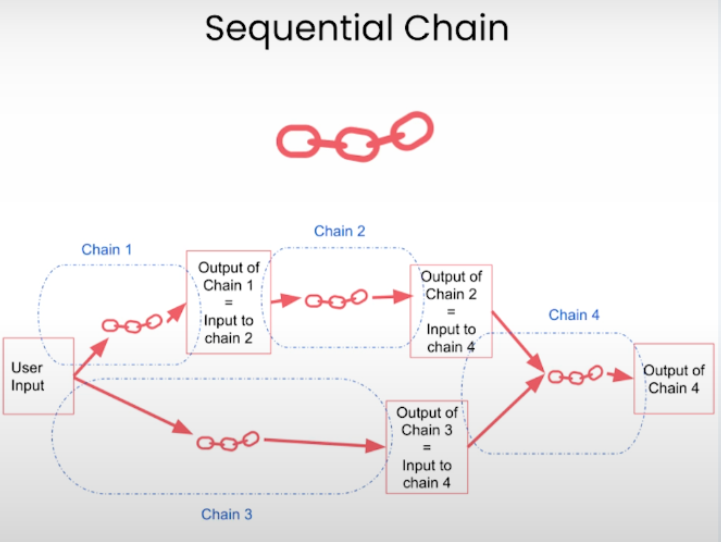

In the example in the following cells, we’ll build a sequential chain to process product reviews, performing multiple transformations on the original input `(Review)` in a chained manner.

The first step `(chain_one)` translates the original review into English. The output of this step is stored in the variable `English_Review`. Next, the second step `(chain_two)` uses this `English_Review` as input and generates a one-sentence summary, stored in the variable `summary`.

In parallel, the third step `(chain_three)` also directly receives the original text `(Review)` and identifies which language it was written in, returning this information in the variable language.

Finally, the fourth step `(chain_four)` uses the `summary` generated in the second step and the language identified in the third to produce a follow-up message in the same language as the original review. The final result is stored in the variable `followup_message`.

In [ ]:
from langchain.chains import SequentialChain

# prompt template 1: translate to english
first_prompt = ChatPromptTemplate.from_template(
    "Translate the following review to english:"
    "\n\n{Review}"
)
# chain 1: input= Review and output= English_Review
chain_one = LLMChain(llm=llm, prompt=first_prompt,
                     output_key="English_Review"
                    )

second_prompt = ChatPromptTemplate.from_template(
    "Can you summarize the following review in 1 sentence:"
    "\n\n{English_Review}"
)
# chain 2: input= English_Review and output= summary
chain_two = LLMChain(llm=llm, prompt=second_prompt,
                     output_key="summary"
                    )

# prompt template 3: translate to english
third_prompt = ChatPromptTemplate.from_template(
    "What language is the following review:\n\n{Review}"
)
# chain 3: input= Review and output= language
chain_three = LLMChain(llm=llm, prompt=third_prompt,
                       output_key="language"
                      )


# prompt template 4: follow up message
fourth_prompt = ChatPromptTemplate.from_template(
    "Write a follow up response to the following "
    "summary in the specified language:"
    "\n\nSummary: {summary}\n\nLanguage: {language}"
)
# chain 4: input= summary, language and output= followup_message
chain_four = LLMChain(llm=llm, prompt=fourth_prompt,
                      output_key="followup_message"
                     )

# overall_chain: input= Review
# and output= English_Review,summary, followup_message
overall_chain = SequentialChain(
    chains=[chain_one, chain_two, chain_three, chain_four],
    input_variables=["Review"],
    output_variables=["English_Review", "summary","followup_message"],
    verbose=True
)

review = df.Review[5]
overall_chain.invoke(review)

Once again, let’s study how to develop the same chain, now using the Runnable-based system. By looking at the next cell, we can already notice one of the advantages of the `SequentialChain` class: the code remains more concise and straightforward. With `Runnables`, the flow quickly becomes more complex. So far, the main new element in the code is the use of `RunnableLambda`, which allows us to insert custom logic directly into the chain flow in a flexible and controlled manner.

```
full_chain = (
    RunnableMap({
        "English_Review": lambda x: translate_chain.invoke({"Review": x["Review"]}),
        "language": lambda x: language_chain.invoke({"Review": x["Review"]}),
    })

```
In this code snippet, we use `RunnableMap` to perform two operations in parallel from the same input `(Review)`:
The first is the translation of the review into English (`translate_chain`), and its result is saved as `English_Review`.

The second is the detection of the original language of the review `(language_chain)`, and its output is saved as `language`.

Next, the role of `RunnableLambda` comes into play in the snippet below. This function is essential for dynamically manipulating the data previously generated and adding new elements to the context dictionary.
In this case:

We receive a dictionary as input with the keys `English_Review` and `language`.

We use `RunnableLambda` to invoke the `summary_chain`, passing the already translated text.

The output `(summary)` is then added to the context using `**x` to preserve the previous information.

```
| RunnableLambda(lambda x: {
    **x,
    "summary": summary_chain.invoke({"English_Review": x["English_Review"]})
})
```

Finally, we use `RunnableLambda` once again to combine multiple variables `(summary and language)` and use them as input for the final step `(followup_chain)`, which generates a follow-up message in the original language.

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableMap, RunnableLambda

# Model & parser
parser = StrOutputParser()

# === Prompt 1: Translate review to English ===
translate_prompt = ChatPromptTemplate.from_template(
    "Translate the following review to english:\n\n{Review}"
)
translate_chain = translate_prompt | llm | parser

# === Prompt 2: Summarize translated review ===
summary_prompt = ChatPromptTemplate.from_template(
    "Can you summarize the following review in 1 sentence:\n\n{English_Review}"
)
summary_chain = summary_prompt | llm | parser

# === Prompt 3: Detect original language ===
language_prompt = ChatPromptTemplate.from_template(
    "What language is the following review:\n\n{Review}"
)
language_chain = language_prompt | llm | parser

# === Prompt 4: Generate follow-up response ===
followup_prompt = ChatPromptTemplate.from_template(
    "Write a follow up response to the following summary in the specified language:"
    "\n\nSummary: {summary}\n\nLanguage: {language}"
)
followup_chain = followup_prompt | llm | parser

# === Full chain logic ===
full_chain = (
    RunnableMap({
        # Step 1: Translate to English
        "English_Review": lambda x: translate_chain.invoke({"Review": x["Review"]}),
        # Step 2: Detect language
        "language": lambda x: language_chain.invoke({"Review": x["Review"]}),
    })
    | RunnableLambda(lambda x: {
        **x,
        # Step 3: Summarize the English review
        "summary": summary_chain.invoke({"English_Review": x["English_Review"]})
    })
    | RunnableLambda(lambda x: {
        **x,
        # Step 4: Generate the follow-up message
        "followup_message": followup_chain.invoke({
            "summary": x["summary"],
            "language": x["language"]
        })
    })
)

# === Run the chain ===
review = df.Review[5]  # assume df is already defined
output = full_chain.invoke({"Review": review})

for key, value in output.items():
    print(f"{key}: {value}")


## 3.4 RouterChain

The last chain we’ll look at in this lesson is the [RouterChain](https://python.langchain.com/api_reference/langchain/chains/langchain.chains.router.base.RouterChain.html). This chain functions like a “decision chain,” dynamically choosing which path to follow based on the input it receives. It analyzes the user input and decides which chain is the most appropriate to process that input. If none of the options are suitable, it uses a default chain.



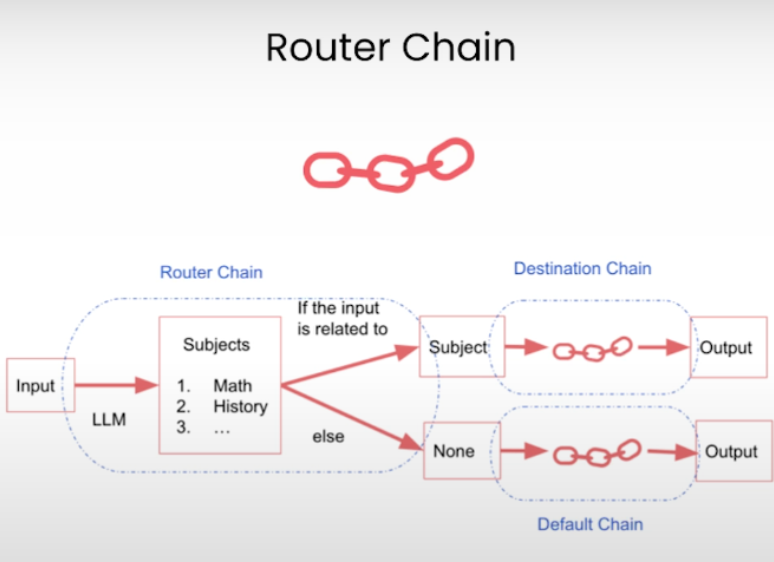

In the following cells, we’ll develop an example of using `RouterChain`. In this example, we implement a Specialist Orchestrator, which receives a user question, processes the input with an LLM, and, based on the content, identifies the subject it relates to — for example: math, history, physics, and so on.

Based on this analysis, the `RouterChain` decides which `Destination Chain` the input should be routed to. If the question is related to math, for instance, it will be directed to the specific chain for that subject, which uses a prompt tailored to handle that type of content.

If the input doesn’t fit into any of the predefined categories, it will be routed to the `Default Chain`, a generic chain responsible for handling cases outside the specialized categories.

For this example, we will not develop it using Runnables, as that would make the code too complex.

First, let’s define the prompt templates.

In [ ]:
physics_template = """You are a very smart physics professor. \
You are great at answering questions about physics in a concise\
and easy to understand manner. \
When you don't know the answer to a question you admit\
that you don't know.

Here is a question:
{input}"""


math_template = """You are a very good mathematician. \
You are great at answering math questions. \
You are so good because you are able to break down \
hard problems into their component parts,
answer the component parts, and then put them together\
to answer the broader question.

Here is a question:
{input}"""

history_template = """You are a very good historian. \
You have an excellent knowledge of and understanding of people,\
events and contexts from a range of historical periods. \
You have the ability to think, reflect, debate, discuss and \
evaluate the past. You have a respect for historical evidence\
and the ability to make use of it to support your explanations \
and judgements.

Here is a question:
{input}"""


computerscience_template = """ You are a successful computer scientist.\
You have a passion for creativity, collaboration,\
forward-thinking, confidence, strong problem-solving capabilities,\
understanding of theories and algorithms, and excellent communication \
skills. You are great at answering coding questions. \
You are so good because you know how to solve a problem by \
describing the solution in imperative steps \
that a machine can easily interpret and you know how to \
choose a solution that has a good balance between \
time complexity and space complexity.

Here is a question:
{input}"""

prompt_infos = [
    {
        "name": "physics",
        "description": "Good for answering questions about physics",
        "prompt_template": physics_template
    },
    {
        "name": "math",
        "description": "Good for answering math questions",
        "prompt_template": math_template
    },
    {
        "name": "History",
        "description": "Good for answering history questions",
        "prompt_template": history_template
    },
    {
        "name": "computer science",
        "description": "Good for answering computer science questions",
        "prompt_template": computerscience_template
    }
]

MULTI_PROMPT_ROUTER_TEMPLATE = """Given a raw text input to a \
language model select the model prompt best suited for the input. \
You will be given the names of the available prompts and a \
description of what the prompt is best suited for. \
You may also revise the original input if you think that revising\
it will ultimately lead to a better response from the language model.

<< FORMATTING >>
Return a markdown code snippet with a JSON object formatted to look like:
```json
{{{{
    "destination": string \ "DEFAULT" or name of the prompt to use in {destinations}
    "next_inputs": string \ a potentially modified version of the original input
}}}}
```

REMEMBER: The value of “destination” MUST match one of \
the candidate prompts listed below.\
If “destination” does not fit any of the specified prompts, set it to “DEFAULT.”
REMEMBER: "next_inputs" can just be the original input \
if you don't think any modifications are needed.

<< CANDIDATE PROMPTS >>
{destinations}

<< INPUT >>
{{input}}

<< OUTPUT (remember to include the ```json)>>"""

Now let’s develop a loop that will define the chains as `LLMChain` instances and store them in a dictionary.

In [ ]:
from langchain.chains.router import MultiPromptChain
from langchain.chains.router.llm_router import LLMRouterChain,RouterOutputParser
from langchain.prompts import PromptTemplate


destination_chains = {}
for p_info in prompt_infos:
    name = p_info["name"]
    prompt_template = p_info["prompt_template"]
    prompt = ChatPromptTemplate.from_template(template=prompt_template)
    chain = LLMChain(llm=llm, prompt=prompt)
    destination_chains[name] = chain

destinations = [f"{p['name']}: {p['description']}" for p in prompt_infos]
destinations_str = "\n".join(destinations)

default_prompt = ChatPromptTemplate.from_template("{input}")
default_chain = LLMChain(llm=llm, prompt=default_prompt)

Now let’s create our RouterChain, using an LLM together with the router_prompt we defined earlier. Then, we’ll use the [MultiPromptChain](https://python.langchain.com/api_reference/langchain/chains/langchain.chains.router.multi_prompt.MultiPromptChain.html) class, which is based on the RouterChain to decide which key from the destination_chains dictionary should be used—that is, which specialized chain will be triggered to process the user’s input.

In [ ]:
router_template = MULTI_PROMPT_ROUTER_TEMPLATE.format(
    destinations=destinations_str
)
router_prompt = PromptTemplate(
    template=router_template,
    input_variables=["input"],
    output_parser=RouterOutputParser(),
)

router_chain = LLMRouterChain.from_llm(llm, router_prompt)

chain = MultiPromptChain(router_chain=router_chain,
                         destination_chains=destination_chains,
                         default_chain=default_chain, verbose=True
                        )



> Entering new MultiPromptChain chain...
physics: {'input': 'What is black body radiation?'}
> Finished chain.


"Black body radiation is the electromagnetic radiation emitted by an idealized object called a black body.  A black body absorbs all electromagnetic radiation incident upon it, regardless of frequency or angle of incidence.  Because it absorbs all radiation, it also emits radiation at all frequencies, with the intensity of that emission depending only on the body's temperature.  The spectrum of this emitted radiation is described by Planck's law."

Now, we can call the chain using the `invoke` method.

In [ ]:
chain.invoke("What is black body radiation?")

In [ ]:
chain.invoke("what is 2 + 2")



> Entering new MultiPromptChain chain...
math: {'input': 'what is 2 + 2'}
> Finished chain.


'The question is: What is 2 + 2?\n\nThis is a simple addition problem.  The component parts are the two numbers, 2 and 2.\n\nAdding them together: 2 + 2 = 4\n\nTherefore, the answer is $\\boxed{4}$.'

In [ ]:
chain.invoke("Why does every cell in our body contain DNA?")



> Entering new MultiPromptChain chain...
None: {'input': 'Why does every cell in our body contain DNA?'}
> Finished chain.


"Every cell in our body (except for mature red blood cells, which lose their nucleus) contains DNA because it serves as the **blueprint for the cell's structure and function**.  DNA holds the genetic instructions needed for:\n\n* **Protein synthesis:** DNA contains the genes that code for the proteins the cell needs to build its structures (like membranes and organelles), carry out its functions (like enzymes and hormones), and regulate its activities.  Without DNA, a cell couldn't produce the necessary proteins to survive.\n\n* **Cell division and replication:**  DNA is replicated before a cell divides, ensuring that each daughter cell receives a complete copy of the genetic instructions. This is crucial for growth, repair, and reproduction of the organism.\n\n* **Cellular differentiation:**  During development, different cells express different genes from the same DNA, leading to the specialization of cells into various types (e.g., nerve cells, muscle cells, skin cells).  This proce